# Plot

## Result 1: Describtion of questionnaire data

In [1]:
# Import datasets
from data_process import *

# Import external libraries
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from pyecharts import options
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
%matplotlib inline
mpl.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in'

### Fig A: comparing actual pop distribution and survey distribution.

Text(0, 0.5, 'Proportion')

Text(0.5, 0, 'Location code')

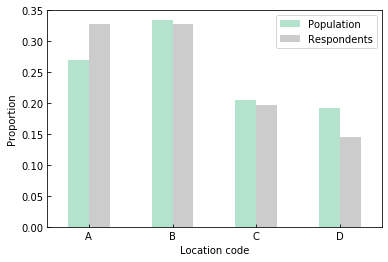

In [2]:
# Processing the distribution of actual population.
k = 1 - 0.2436
city_rate = 0.55
pop['location_code'] = pop['location'].str[0]
for index in range(len(pop)):
    if pop.loc[index, "location"] == "A":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] / 3
    elif pop.loc[index, "location"][0] == "B":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] * k
    elif pop.loc[index, "location"] in ["C1", "C2"]:
        pop.loc[index, "use_pop"] = pop.loc[index, "city"]
    elif pop.loc[index, "location"] == "C3":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] * k 
    elif pop.loc[index, "location"][0] == "D":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] * city_rate
        
pop_distribution = pop.groupby("location_code")['use_pop'].mean().astype(int)
pop_distribution = pop_distribution / pop_distribution.sum()

sample_distribution = questionnaires['location_code'].value_counts() / len(questionnaires)
distribution = pd.DataFrame({
    'location': pop_distribution.index,
    'Population': pop_distribution.values,
    'Respondents': sample_distribution.values
})

fig, ax1 = plt.subplots()
distribution.plot(kind='bar', x='location', rot=0, ax=ax1, colormap='Pastel2')
ax1.set_ylabel("Proportion")
ax1.set_xlabel("Location code")

### Fig B：Catalogues of respondents

In [3]:
gender_ratio = questionnaires['men'].sum() / questionnaires['women'].sum()
gender_ratio_census = 2789 / 2672  # data from http://data.stats.gov.cn
print("gender ratio of our survey is {:.2f}, while in census data {:.2f}".format(gender_ratio, gender_ratio_census))

farm_ratio = questionnaires['farm'].sum() / len(questionnaires)
farm_ratio_census = 283 / 688
print("farm proportion of our survey is {:.2%}, while in census data {:.2%}".format(farm_ratio, farm_ratio_census))

gender ratio of our survey is 1.00, while in census data 1.04
farm proportion of our survey is 43.23%, while in census data 41.13%


In [39]:
memory_map = {
    'heard of somewhere': 'Heard of',
    'heard from intimates': 'Heard of',
    'know from written records': 'Read about',
    'experienced': 'Experienced'
}
questionnaires_2 = questionnaires.replace(memory_map, inplace=False, regex=True)

catalogue_farm = ['farm', 'off-farm'] 
catalogue_memory = ["Heard of", "Read about", "Experienced"] 
catalogue_education = list(questionnaires_2['education'].dropna().unique())
catalogues = catalogue_farm + catalogue_memory + catalogue_education

links = []
colors = {'farm': 'goldenrod', 'off-farm': 'mediumseagreen'}
numbers = {'farm': len(questionnaires_2[questionnaires_2['farm']]),
          'off-farm': len(questionnaires_2) - len(questionnaires_2[questionnaires_2['farm']])}

numbers

def add_farm_to_memory_sankey(data, source, links):
    n = 0
    answers = []
    for year in MAJOR_HISTORICAL_FLOODS:
        answers += list(data[str(year)].values)
    answer_dict = {}
    for answer in answers:
        tmp_list = answer.split("; ")
        for item in tmp_list:
            if item in catalogue_memory:
                n += 1
                if item in answer_dict:
                    answer_dict[item] += 1
                else:
                    answer_dict[item] = 1           
    for how_get_known, value in answer_dict.items():
        links.append({
            'source': source,
            'target': how_get_known,
            'value': value / n,
            'type': source,
            'color': colors[source]
        }) 
    return links


farm_data = questionnaires_2[questionnaires_2['farm']]
links = add_farm_to_memory_sankey(farm_data, 'farm', links)
off_farm_data = questionnaires_2[questionnaires_2['farm'] == False]
links = add_farm_to_memory_sankey(off_farm_data, 'off-farm', links)

farm_to_education = questionnaires_2.pivot_table(index=['farm', 'education'], values='valid', aggfunc=np.count_nonzero)
for source, value in farm_to_education.loc[True]['valid'].items():
    links.append({
        'source': source,
        'target': 'farm',
        'value': value / numbers['farm'],
        'type': 'farm',
        'color': colors['farm']
    })

    
off_farm_to_education = questionnaires_2.pivot_table(index=['farm', 'education'], values='valid', aggfunc=np.count_nonzero)
for source, value in farm_to_education.loc[False]['valid'].items():
    links.append({
        'source': source,
        'target': 'off-farm',
        'value': value / numbers['off-farm'],
        'type': 'off-farm',
        'color': colors['off-farm']
    })

    
layout = Layout(width="600", height="300")
SankeyWidget(links=links, layout=layout).auto_save_png('images/sankey.png')

{'farm': 262, 'off-farm': 344}

SankeyWidget(layout=Layout(height='300', width='600'), links=[{'source': 'farm', 'target': 'Heard of', 'value'…

### Fig C: Memory of major flooding

Text(0.5, 0, 'Major historical ﬂoods')

Text(0, 0.5, 'Number of respondents')

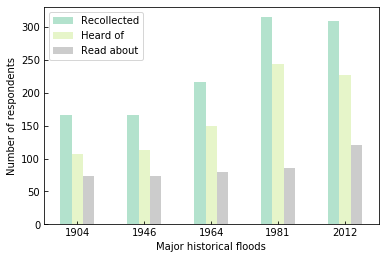

In [5]:
major_floods = water_level.loc[MAJOR_HISTORICAL_FLOODS]
fre = stats_fre_questionnaris(questionnaires, MAJOR_HISTORICAL_FLOODS, normalize=False)
fre['Recollected'], fre['Heard of'], fre['Read about'] = fre['collective'], fre['communicative'], fre['cultural']
fig, ax2 = plt.subplots()
fre[['Recollected', 'Heard of', 'Read about']].plot(kind='bar', ax=ax2, rot=0, colormap='Pastel2')
ax2.set_xlabel("Major historical ﬂoods")
ax2.set_ylabel("Number of respondents")

### Fig D: Relative collective memory

Text(0.5, 0, 'Major historical floods')

Text(0, 0.5, 'Recollection scaled by relative flooding level')

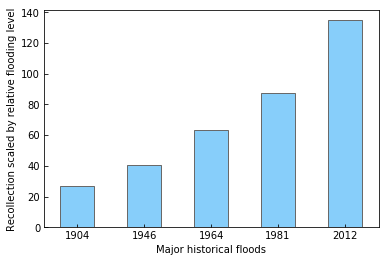

In [36]:
ratio = (major_floods['flood_level'] - W_MIN)
scaled = fre['collective'] / ratio


fig, ax3 = plt.subplots()
scaled.plot(kind='bar', rot=0, ax=ax3, color='lightskyblue', edgecolor='dimgrey')
ax3.set_xlabel("Major historical floods")
ax3.set_ylabel("Recollection scaled by relative flooding level")

### Fig E: Scores

Text(0.5, 0, 'Scores')

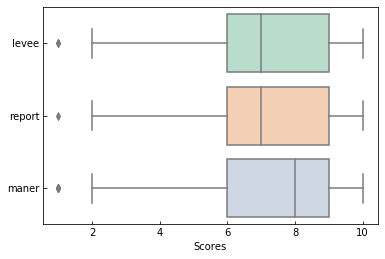

In [7]:
fig, ax6 = plt.subplots()
sns.boxplot(data=questionnaires[['levee', 'report', 'maner']], orient='h', ax=ax6, palette='Pastel2')
ax6.set_xlabel("Scores")

Text(0, 0.5, 'Proportion')

Text(0.5, 0, 'Location code')

Text(0.5, 0, 'Major historical ﬂoods')

Text(0, 0.5, 'Number of respondents')

Text(0.5, 0, 'Major historical floods')

Text(0.5, 0, 'Scores')

(0, 10)

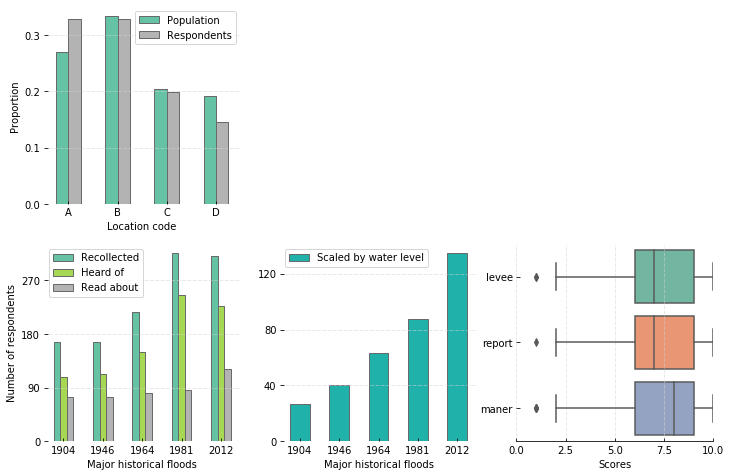

In [37]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(12, 8))

# fig A:
distribution.plot(kind='bar', x='location', rot=0, edgecolor='dimgrey', ax=ax1, colormap='Set2')
ax1.set_ylabel("Proportion")
ax1.set_xlabel("Location code")

# Fig B
# add Sankey plot outside Jupyter Notebook
for ax in [ax2, ax3]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Fig C:
fre[['Recollected', 'Heard of', 'Read about']].plot(kind='bar', ax=ax4, edgecolor='dimgrey', rot=0, colormap='Set2')
ax4.set_xlabel("Major historical ﬂoods")
ax4.set_ylabel("Number of respondents")

# fig D
scaled.plot(kind='bar', rot=0, ax=ax5, 
            color='lightseagreen', label='Scaled by water level',
            edgecolor='dimgrey')
ax5.set_xlabel("Major historical floods")
ax5.legend()
# ax5.set_ylabel("Recollection scaled by relative flooding level")

# fig E
sns.boxplot(data=questionnaires[['levee', 'report', 'maner']], 
            orient='h', ax=ax6, palette='Set2')
ax6.set_xlabel("Scores")
ax6.set_xlim(0, 10)

for ax in [ax1, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
for ax in [ax1, ax4, ax5]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5)
ax1.set_yticks(np.arange(0, 0.4, 0.1))
ax4.set_yticks(np.arange(0, 350, 90))
ax5.set_yticks(np.arange(0, 160, 40))
ax6.spines['bottom'].set_visible(True)
ax6.set_xticks(np.arange(0, 10.1, 2.5))
ax6.xaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5)

plt.savefig('images/result1.jpg', format='jpg', dpi=300)



# Result 2: Decay of collective memory

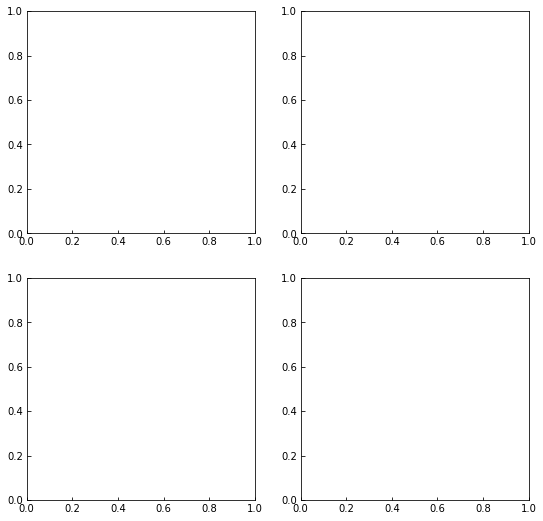

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

In [10]:
# Actural flooding water level, levee height

major_floods = water_level.loc[MAJOR_HISTORICAL_FLOODS]
memory = stats_fre_questionnaris(questionnaires, MAJOR_HISTORICAL_FLOODS, normalize=True)

for y in MAJOR_HISTORICAL_FLOODS:
    major_floods.loc[y, 'height_levee'] = get_actual_levee_height(y)



wl = major_floods['flood_level'].plot(kind='bar', color='blue', label='flooding water level', ax=ax1)
lh = major_floods['height_levee'].plot(kind='bar', color='gray', label='levee height', ax=ax1)
ax1.set_ylim(W_MIN-1, W_MAX)
ax1.set_xlabel("Major historical ﬂood")
ax1.set_ylabel("Elevation / m")
ax1.legend()

(1134.3, 1141.5)

Text(0.5, 270.05818181818177, 'Major historical ﬂood')

Text(3.200000000000003, 0.5, 'Elevation / m')